# Containerised Jupyter Notebook Access from Docker Container

## Introduction

In [1]:
print('Hello world from Dockerised AMICI')

Hello world from Dockerised AMICI


In [2]:
import os 
path = os.getcwd()
print('Current working directory:', path)

# change the working directory to '/\new-peak-project'

os.chdir('/new-peak-project/src')
print('Changed working directory to:', os.getcwd())

Current working directory: /app
Changed working directory to: /new-peak-project/src


In [3]:
# set the results directory to '/new-peak-project/src/experiments'

results_path = '/new-peak-project/src/experiments'

In [4]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import ModelSpecification

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

import amici

In [6]:
import os 

### parameters 
notebook_name = 'generate_large_model'
sub_id = '1'

## Generation of ground truth model 
model_name = 'v3_small_model_52'
o_random_seed = 6 
parameter_random_seed = 6
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 
simulation_time = 500 
simulation_step = 100

## Feature data generation 
feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 
'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
'''

# Engineering Feature Data 
data_engineering_method = 'dynamic_feature'
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + sub_id
experiment_folder = results_path + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

os.environ['CC'] = 'clang'
os.environ['CXX'] = 'clang'
os.environ['AMICI_EXTRACT_CSE'] = '1'
# os.environ['AMICI_IMPORT_NPROCS'] = '6'
# os.environ['AMICI_PARALLEL_COMPILE'] = '6'

/new-peak-project/src/experiments/generate_large_model_1/


In [7]:
### Generate the ground truth model
seed = 4
parameter_random_seed = 4
num_species = 5
num_feedback = 2
model_name = f'example_model_{seed}_{parameter_random_seed}_{num_species}_{num_feedback}'

model_spec = ModelSpecification()
model_spec.generate_specifications(seed, num_species, num_feedback, verbose=0)
# G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=parameter_random_seed, verbose=0)
# runner = roadrunner.RoadRunner(G0.get_sbml_model())

In [8]:
G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=parameter_random_seed, verbose=0)

In [9]:
print(G0)

Model Name example_model_4_4_5_2
Number of Reactions 22
Number of State Variables 22
Number of Parameters 56
Number of Custom Variables 0
Number of Enforced State Values 0
Number of Custom Strings 0



In [10]:
# save the sbml model to the results folder
sbml_file = experiment_folder + model_name + '.xml'
with open(sbml_file, 'w') as f:
    f.write(G0.get_sbml_model())
print('SBML model saved to:', sbml_file)

SBML model saved to: /new-peak-project/src/experiments/generate_large_model_1/example_model_4_4_5_2.xml


## Use AMICI to simulate model

In [11]:
import amici

sbml_importer = amici.SbmlImporter(f"/new-peak-project/src/experiments/generate_large_model_1/{model_name}.xml")

In [12]:
import logging
model_dir = "model_dir"
sbml_importer.sbml2amici(model_name, model_dir, verbose=logging.INFO, generate_sensitivity_code=False, constant_parameters=False, simplify=None)

2025-05-06 09:07:35.432 - amici.sbml_import - INFO - Finished importing SBML                         (1.00E-01s)
2025-05-06 09:07:35.482 - amici.sbml_import - INFO - Finished processing SBML observables            (4.36E-02s)
2025-05-06 09:07:35.490 - amici.sbml_import - INFO - Finished processing SBML event observables      (1.20E-06s)
2025-05-06 09:07:35.565 - amici.de_model - INFO - Finished computing xdot                            (2.19E-04s)
2025-05-06 09:07:35.572 - amici.de_model - INFO - Finished computing x0                              (1.50E-04s)
2025-05-06 09:07:35.578 - amici.de_model - INFO - Finished computing w                               (1.34E-04s)
2025-05-06 09:07:36.828 - amici.de_export - INFO - Finished generating cpp code                      (1.24E+00s)
2025-05-06 09:07:53.595 - amici.de_export - INFO - Finished compiling cpp code                       (1.68E+01s)


In [13]:
model_dir = "model_dir"
# load the model module
model_module = amici.import_model_module(model_name, model_dir)
# instantiate model
model = model_module.getModel()
# instantiate solver
solver = model.getSolver()

In [14]:
solver.setAbsoluteTolerance(1e-10)

In [74]:
# Create Model instance
model = model_module.getModel()

# set timepoints for which we want to simulate the model
model.setTimepoints(np.linspace(0, 500, 500))

# Create solver instance
solver = model.getSolver()

# Run simulation using default model parameters and solver options
rdata = amici.runAmiciSimulation(model, solver)

In [75]:
print(
    "Simulation was run using model default parameters as specified in the SBML model:"
)
print(dict(zip(model.getParameterIds(), model.getParameters())))

Simulation was run using model default parameters as specified in the SBML model:
{'J0_Vmax': 109.83616177738, 'J0_Km': 994.773880742686, 'J1_Vmax': 1.37716909709473, 'J1_Km': 287.919483927338, 'J2_Vmax': 25.0510640113985, 'J2_Km': 514.2750718556, 'J3_Vmax': 8.68774052034755, 'J3_Kw0': 0.297452056544061, 'J3_Km': 568.601041978935, 'J4_Vmax': 6.25678153880696, 'J4_Km': 578.345752247965, 'J5_Vmax': 4.84261930674184, 'J5_Km': 135.162559793197, 'J5_Kic0': 0.695612627432444, 'J6_Vmax': 40.2712349737603, 'J6_Km': 672.467917313973, 'J7_Vmax': 60.3335450875878, 'J7_Km': 557.800320151023, 'J8_Vmax': 72.8383313294636, 'J8_Km': 612.893484463085, 'J9_Vmax': 58.7853281640823, 'J9_Km': 382.400314545562, 'J10_Vmax': 82.2771301667924, 'J10_Km': 601.109760458608, 'J11_Vmax': 0.944086618170318, 'J11_Kw0': 0.842802245443291, 'J11_Km': 630.493080698593, 'J12_Vmax': 45.0879753304262, 'J12_Km': 981.844663287995, 'J13_Vmax': 9.11917267264712, 'J13_Kw0': 0.099290034672555, 'J13_Km': 695.88921699178, 'J14_Vmax

In [76]:
time_points = rdata.ts
res = rdata.x.T
res_states = model.getStateNames()

In [77]:
print(res.shape)

(22, 500)


In [78]:
states = model.getStateIds()
# set C to 1000 

# model.setInitialStates()

inits = list(model.getInitialStates())
print(inits)
print(states)

state_to_change = {'C': 1000}

for s in state_to_change.keys():
    if s in states:
        index = states.index(s)
        inits[index] = state_to_change[s]
    else:
        print(f"State {s} not found in model states.")
model.setInitialStates(inits)
inits = list(model.getInitialStates())
print(inits)

[0.0, 4494.0, 0.0, 1416.0, 0.0, 0.0, 4344.0, 0.0, 0.0, 4288.0, 0.0, 4812.0, 4266.0, 0.0, 1737.0, 0.0, 870.0, 0.0, 2039.0, 0.0, 3732.0, 100.0]
('A0p', 'A0', 'A1p', 'A1', 'Cp', 'A2p', 'A2', 'B0p', 'A3p', 'A3', 'A4p', 'A4', 'B0', 'B1p', 'B1', 'B2p', 'B2', 'B3p', 'B3', 'B4p', 'B4', 'C')
[0.0, 4494.0, 0.0, 1416.0, 0.0, 0.0, 4344.0, 0.0, 0.0, 4288.0, 0.0, 4812.0, 4266.0, 0.0, 1737.0, 0.0, 870.0, 0.0, 2039.0, 0.0, 3732.0, 1000.0]


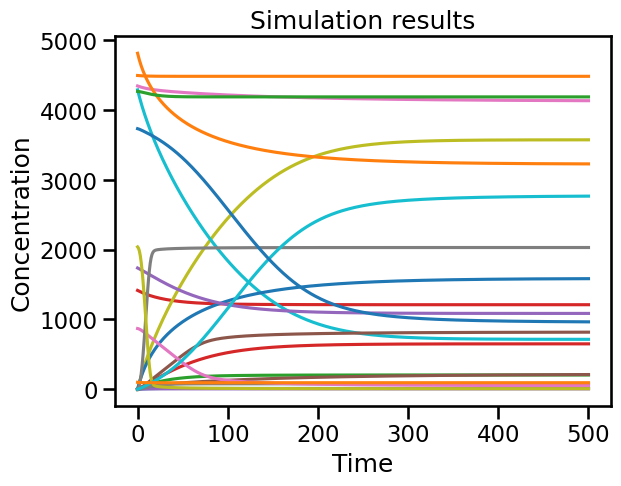

In [79]:
# use matplotlib to plot the results of each res 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.axes_style('whitegrid')

for i in range(res.shape[0]):
    plt.plot(time_points, res[i,:], label=res_states[i])
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Simulation results')
plt.show()

In [80]:
# set timepoints for which we want to simulate the model
model = model_module.getModel()

model.setTimepoints(np.linspace(0, 500, 500))

# Create solver instance
solver = model.getSolver()

# Run simulation using default model parameters and solver options
rdata = amici.runAmiciSimulation(model, solver)

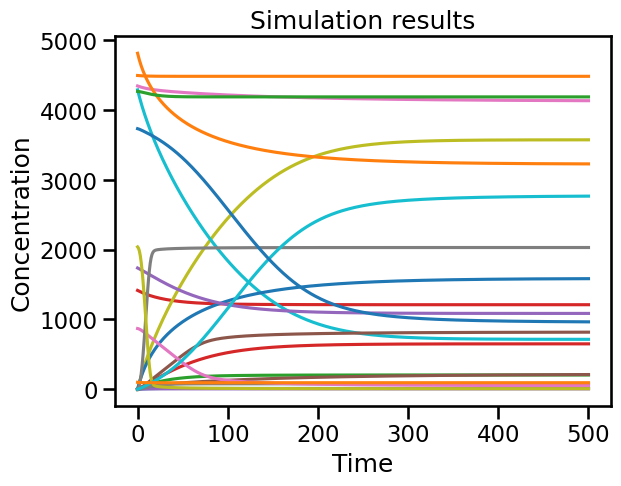

In [81]:
# use matplotlib to plot the results of each res
time_points = rdata.ts
res = rdata.x.T
res_states = model.getStateNames()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.axes_style('whitegrid')

for i in range(res.shape[0]):
    plt.plot(time_points, res[i, :], label=res_states[i])
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Simulation results')
plt.show()

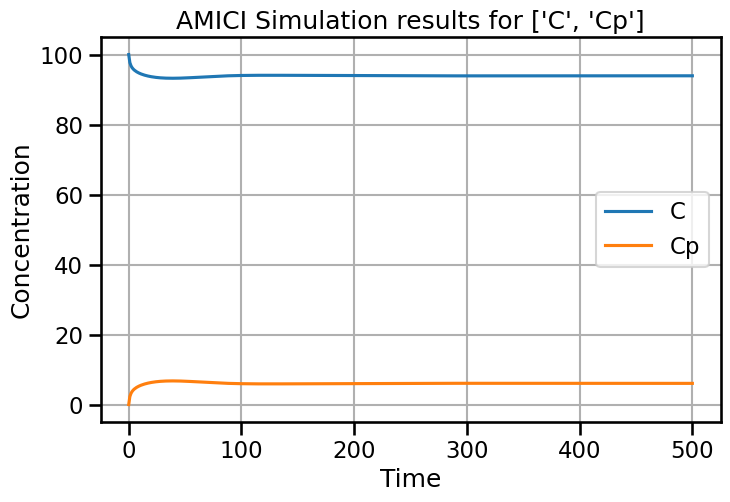

In [82]:
# only plot C and Cp 

states_plot = ['C', 'Cp']
states_plot_index = {}
for state in states_plot:
    for i in range(len(res_states)):
        if state == res_states[i]:
            states_plot_index[state] = i
            break
        
plt.figure(figsize=(8, 5))
for state in states_plot:
    plt.plot(time_points, res[states_plot_index[state],:], label=state)
    
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('AMICI Simulation results for ' + str(states_plot))
plt.legend()
plt.grid()
plt.show()

## Using the Solver Abstraction layer

In [11]:
from models.Solver.AMICISolver import AMICISolver

new_solver = AMICISolver()

In [12]:
### Generate the ground truth model

model_spec = ModelSpecification()
model_spec.generate_specifications(4, 5, 2, verbose=0)
G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=4, verbose=0)
states_variable_names = G0.get_state_variables().keys()

# save the sbml model to the results folder
sbml_file = experiment_folder + model_name + '.xml'
with open(sbml_file, 'w') as f:
    f.write(G0.get_sbml_model())
print('SBML model saved to:', sbml_file)

SBML model saved to: /new-peak-project/src/experiments/generate_large_model_1/example_model_4_4_5_2.xml


In [13]:
kw = {'model_dir': 'model_dir', 'model_name': model_name}
new_solver.compile(sbml_file, **kw)

2025-05-06 09:44:01.407 - amici.sbml_import - INFO - Finished importing SBML                         (1.25E-01s)
2025-05-06 09:44:01.463 - amici.sbml_import - INFO - Finished processing SBML observables            (4.74E-02s)
2025-05-06 09:44:01.471 - amici.sbml_import - INFO - Finished processing SBML event observables      (1.40E-06s)
2025-05-06 09:44:01.554 - amici.de_model - INFO - Finished computing xdot                            (2.18E-04s)
2025-05-06 09:44:01.562 - amici.de_model - INFO - Finished computing x0                              (1.59E-04s)
2025-05-06 09:44:01.568 - amici.de_model - INFO - Finished computing w                               (1.73E-04s)
2025-05-06 09:44:02.773 - amici.de_export - INFO - Finished generating cpp code                      (1.19E+00s)
2025-05-06 09:44:18.378 - amici.de_export - INFO - Finished compiling cpp code                       (1.56E+01s)


In [33]:
new_solver.set_parameter_values({'J1_Vmax': 1000})

result = new_solver.simulate(0, simulation_time, simulation_step)
result

,time,A0p,A0,A1p,A1,Cp,A2p,A2,B0p,A3p,...,B0,B1p,B1,B2p,B2,B3p,B3,B4p,B4,C
0,0.000000,0.000000,4494.000000,0.000000,1416.000000,0.000000,0.000000,4344.000000,0.000000,0.000000,...,4266.000000,0.000000,1737.000000,0.000000,870.000000,0.000000,2039.000000,0.000000,3732.000000,100.000000
1,5.050505,4003.223604,490.776396,30.801583,1385.198417,5.499061,2.591786,4341.408214,4248.160878,238.413301,...,17.839122,34.488995,1702.511005,9.103345,860.896655,347.232015,1691.767985,25.939296,3706.060704,94.500939
2,10.101010,4465.583946,28.416054,59.642764,1356.357236,9.551204,2.710148,4341.289852,4253.690556,437.491178,...,12.309444,71.569588,1665.430412,11.656660,858.343340,1223.359832,815.640168,58.164746,3673.835254,90.448796
3,15.151515,4465.584900,28.415100,86.581676,1329.418324,12.837692,2.822245,4341.177755,4253.690561,613.676403,...,12.309439,110.485883,1626.514117,12.484958,857.515042,1890.838470,148.161530,92.619174,3639.380826,87.162308
4,20.202020,4465.584900,28.415100,111.684046,1304.315954,15.506514,2.928431,4341.071569,4253.690561,774.178522,...,12.309439,150.662848,1586.337152,12.905449,857.094551,1993.608756,45.391244,129.770711,3602.229289,84.493486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,479.797980,4465.584900,28.415100,379.978990,1036.021010,26.218593,4.828810,4339.171190,4253.690561,3572.499836,...,12.309439,1048.971024,688.028976,18.453122,851.546878,2030.394568,8.605432,2764.782910,967.217090,73.781407
96,484.848485,4465.584900,28.415100,379.978944,1036.021056,26.218538,4.829558,4339.170442,4253.690561,3572.553862,...,12.309439,1048.977882,688.022118,18.455332,851.544668,2030.394700,8.605300,2765.191074,966.808926,73.781462
97,489.898990,4465.584900,28.415100,379.978853,1036.021147,26.218488,4.830267,4339.169733,4253.690561,3572.602143,...,12.309439,1048.983827,688.016173,18.457426,851.542574,2030.394817,8.605183,2765.576420,966.423580,73.781512
98,494.949495,4465.584900,28.415100,379.978726,1036.021274,26.218442,4.830938,4339.169062,4253.690561,3572.645291,...,12.309439,1048.988969,688.011031,18.459410,851.540590,2030.394923,8.605077,2765.940280,966.059720,73.781558


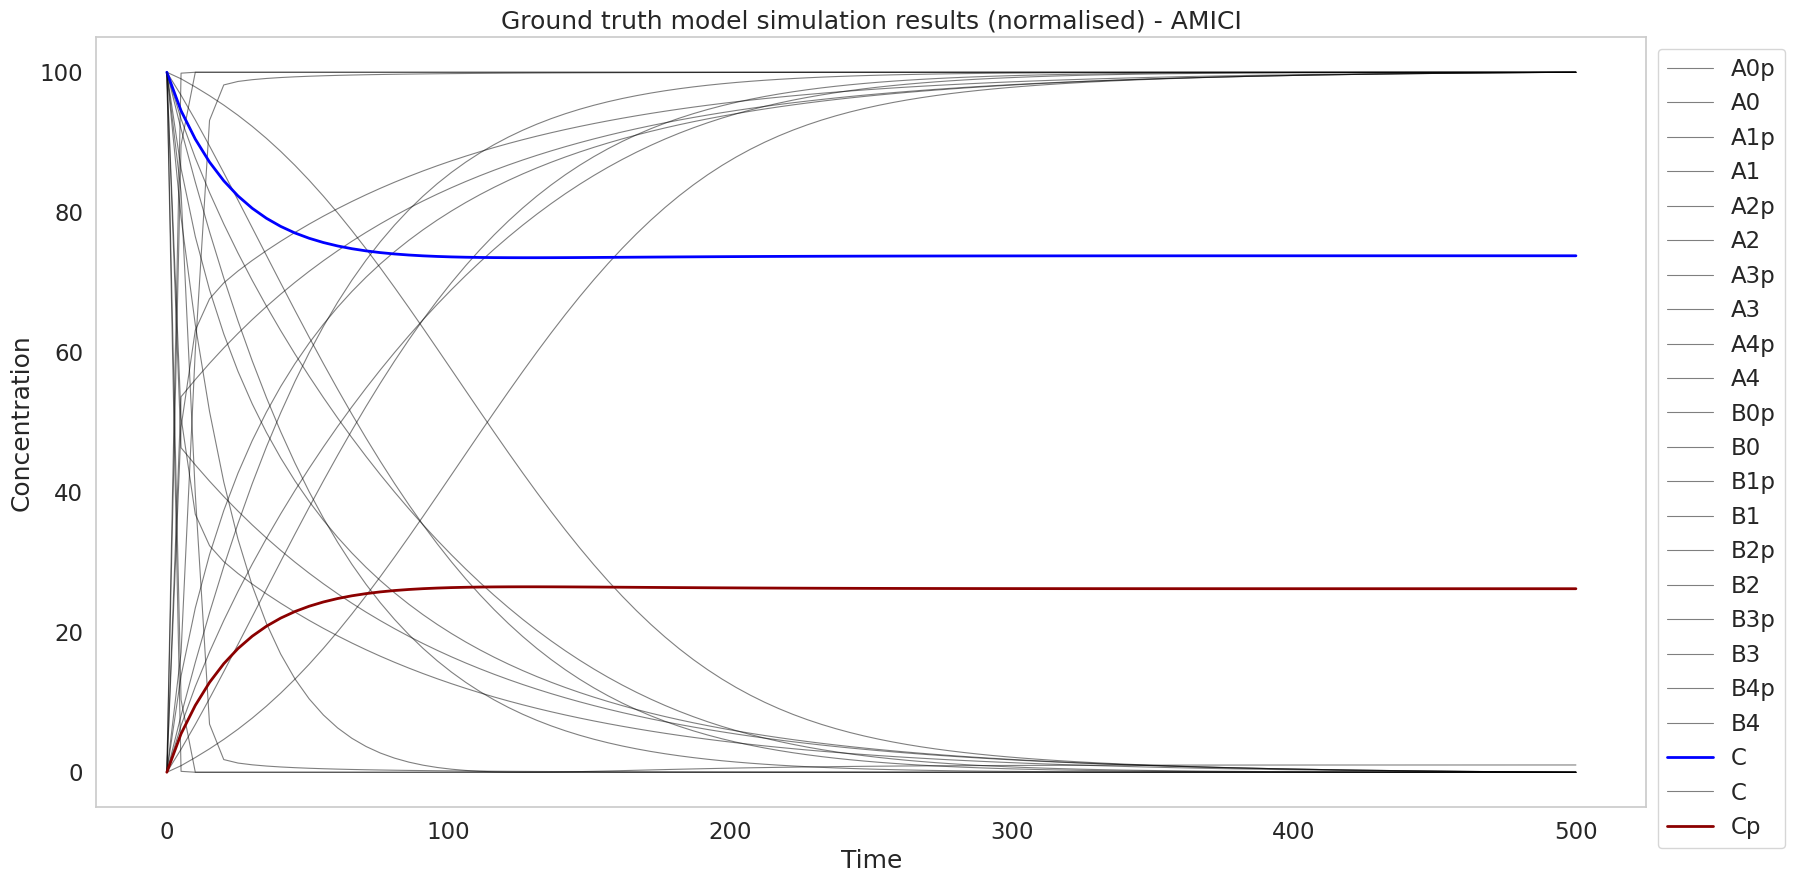

In [34]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Ground truth model simulation results (normalised) - AMICI')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

In [35]:
result = new_solver.simulate(0, simulation_time, simulation_step)

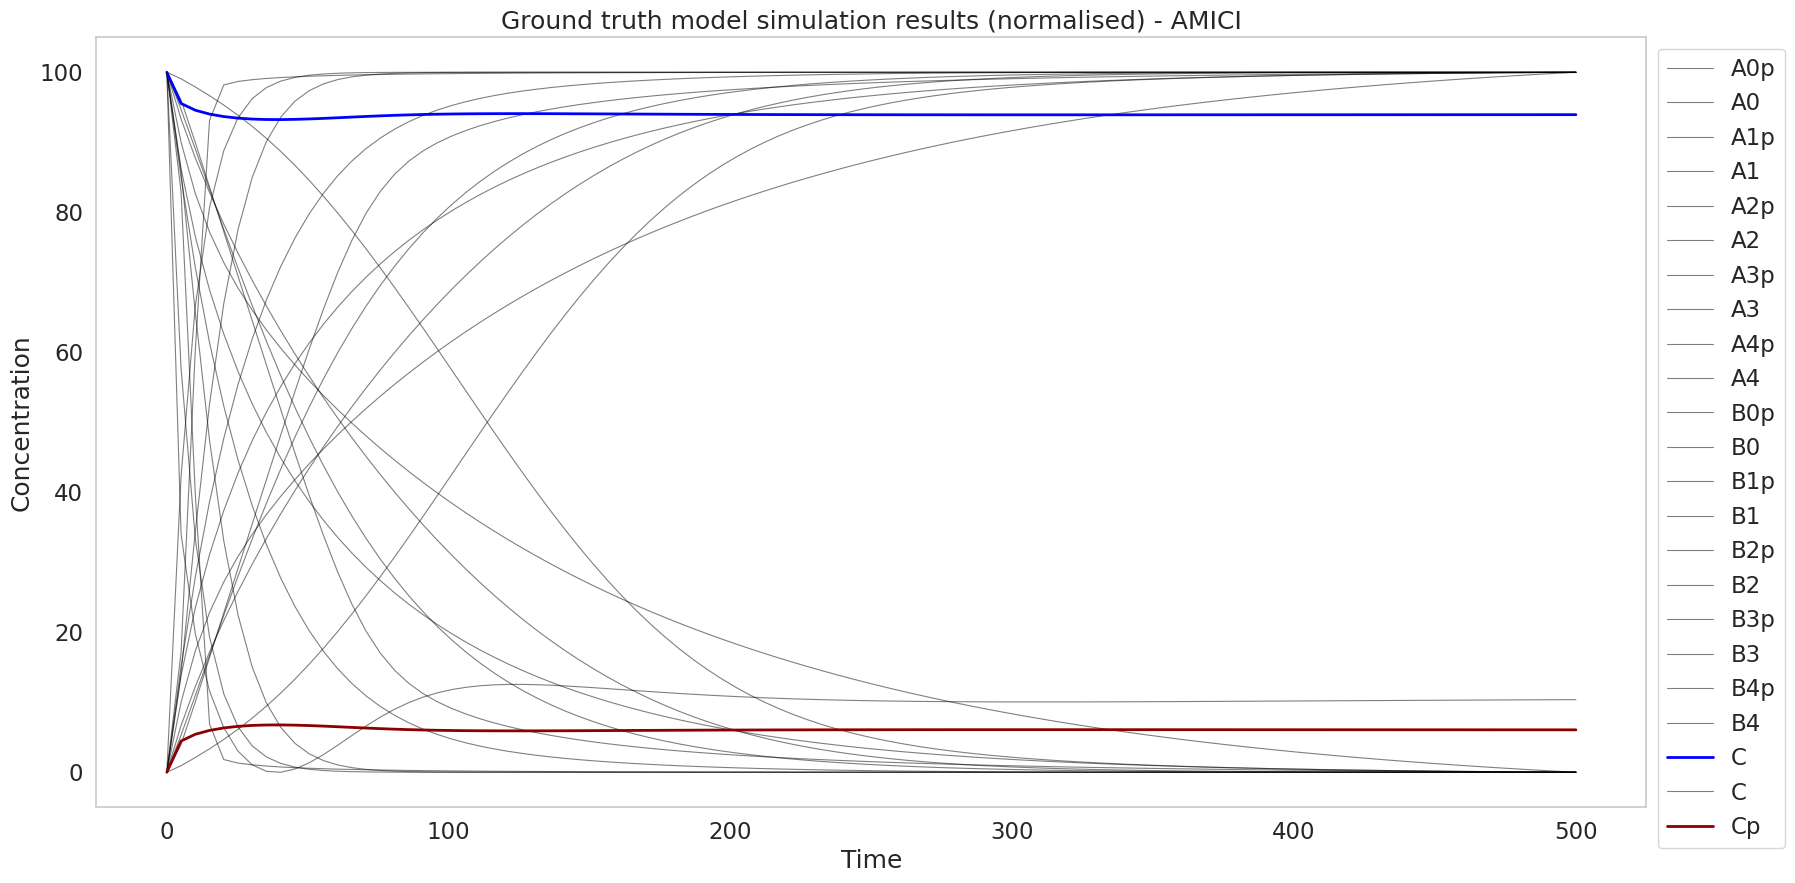

In [36]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Ground truth model simulation results (normalised) - AMICI')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()